In [0]:
'''
from google.colab import drive
drive.mount('/content/drive')

base_path = './drive/My Drive/Colab Notebooks/CycleGAN'
'''

base_path = '.'

### Import statements

In [2]:
# import statements
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization #for normalization in each feature map locally only
from keras.initializers import RandomNormal
from keras.layers import Layer # https://keras.io/layers/writing-your-own-keras-layers/ - for custom layer creation
import tensorflow as tf
import numpy as np
from keras.engine import InputSpec
from keras.models import Model, Input
from keras.layers import Conv2D, Conv2DTranspose, Activation, add, LeakyReLU, Concatenate
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from os import listdir
from numpy import asarray, load, savez_compressed
from keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm 
import random
import time
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-7iysm5mf
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-7iysm5mf
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp35-none-any.whl size=101239 sha256=288a7880f66060bcb69989315c5737dceaa4985be09695bee2d3b0b963e301dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-j23ch02f/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


Using TensorFlow backend.


### Reflection Padding custom layer definition

In [0]:
# Reflection padding with example - http://www-cs.engr.ccny.cuny.edu/~wolberg/cs470/hw/hw2_pad.txt
# Code taken from - https://github.com/fastai/courses/blob/master/deeplearning2/neural-style.ipynb
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

### Generator model definition

In [4]:
# Generator

# https://github.com/simontomaskarlsson/CycleGAN-Keras/blob/master/model.py - official implementation
# https://towardsdatascience.com/cyclegan-learning-to-translate-images-without-paired-training-data-5b4e93862c8d - model reference

def generator(input_shape=(256,256,3), name='generator'):

  # Model mentioned for 256X256 input for horse2zebra dataset in CycleGAN paper (appendix)
  # -- c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

  # weight initialization
  init = RandomNormal(stddev=0.02) #mentioned in paper for weight initialization

  # define input 
  input_img = Input(shape = input_shape)
  
  x = ReflectionPadding2D((3, 3))(input_img) # used to reduce artifacts in image - technique mentioned in paper

  # layer 1: c7s1-64
  x = Conv2D(filters=64, kernel_size=7, strides=1, padding='valid', kernel_initializer=init)(x)
  # https://stackoverflow.com/questions/57320371/what-does-training-true-mean-when-calling-a-tensorflow-keras-model - regarding training=true
  # training=true implements the layer (in this case the normalization layer) only in training phase. Not in inference phase
  # https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py - instance normaliation doc
  x = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x)  
  # epsilon to avoid divide by zero error on normalization
  # https://deeplizard.com/learn/video/AiyK0idr4uM - about axis numbers in tensorflow
  # axis = 3 -> normalize each channel/filter
  x = Activation('relu')(x)        

  # layer 2: d128
  x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(x)
  # strides=2 makes it down convolution
  x = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x)
  x = Activation('relu')(x)        
  
  # layer 3: d256
  x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(x)
  x = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x)
  x = Activation('relu')(x)

  # layer 4-12 residual blocks 
  # 9 blocks as input image dimension is 256X256 - mentioned in paper
  for i in range(9):
    # R256 - 2 layers
    # first layer 
    x1 = ReflectionPadding2D((1,1))(x)
    x1 = Conv2D(filters=256, kernel_size=3, strides=1, padding='valid', kernel_initializer=init)(x1) #valid padding as refection padding in previous step aguments the input
    x1 = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x1)
    x1 = Activation('relu')(x1)
    
    # second layer
    x1 = ReflectionPadding2D((1, 1))(x1)
    x1 = Conv2D(filters=256, kernel_size=3, strides=1, padding='valid', kernel_initializer=init)(x1)
    x1 = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x1)
    
    # merge input with output and cycle it back as input for next layer
    x = Concatenate()([x1, x])

  # Layer 13: u128
  x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(x)  # downsampling
  x = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x)
  x = Activation('relu')(x)

  # Layer 14: u64
  x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(x) # downsampling
  x = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x)
  x = Activation('relu')(x)

  # layer 15: c7s1-3
  x = ReflectionPadding2D((3, 3))(x)
  x = Conv2D(filters=3, kernel_size=7, strides=1, padding='valid', kernel_initializer=init)(x) #chosen valid padding to retain output image shape as 256X256
  output_img = Activation('tanh')(x)  # tanh used as mentioned in official implementation of CycleGAN

  model = Model(inputs=input_img, outputs=output_img, name=name)
  return model
'''
# https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/ - for graph visualization
gen_1 = generator()
plot_model(gen_1, to_file=base_path + '/generator.png', show_shapes=True, show_layer_names=True)
'''

"\n# https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/ - for graph visualization\ngen_1 = generator()\nplot_model(gen_1, to_file=base_path + '/generator.png', show_shapes=True, show_layer_names=True)\n"

### Discriminator model definition

In [5]:
# Discriminator
# Using PatchGAN discriminator architecture to retain only high level features and leave low level features to L1 loss function
# https://arxiv.org/pdf/1611.07004.pdf - PatchGAN paper

def discriminator(input_shape=(256,256,3), name = 'discriminator'):

  # weight initialization
  init = RandomNormal(stddev=0.02) # mentioned in paper

  # define input 
  input_img = Input(shape = input_shape)

  # Layer 1 C64: downsampling to 128X128
  x = Conv2D(filters=64, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(input_img)
  x = LeakyReLU(alpha=0.2)(x) # slope as mentioned in appendix of paper

  # Layer 2 C128: downsampling to 64X64
  x = Conv2D(filters=128, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(x)
  x = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x, training=True)
  x = LeakyReLU(alpha=0.2)(x)

  # Layer 3 C256:  downsampling to 32X32
  x = Conv2D(filters=256, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(x)
  x = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x, training=True)
  x = LeakyReLU(alpha=0.2)(x)

  # Layer 4 C512: 32X32
  x = Conv2D(filters=512, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(x)
  x = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(x, training=True)
  x = LeakyReLU(alpha=0.2)(x)

  # Output layer 32X32X1
  output_patch = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', kernel_initializer=init)(x)
  
  model = Model(inputs=input_img, outputs=output_patch, name=name)
  model.compile(optimizer=Adam(0.0002, 0.5, 0.999),loss=lse,loss_weights=[0.5]) #loss_weights=0.5 to train discriminator slower than generator
  return model
'''
# https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/ - for graph visualization
dis_1 = discriminator()
plot_model(dis_1, to_file=base_path + '/discriminator.png', show_shapes=True, show_layer_names=True)
'''

"\n# https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/ - for graph visualization\ndis_1 = discriminator()\nplot_model(dis_1, to_file=base_path + '/discriminator.png', show_shapes=True, show_layer_names=True)\n"

### Loss functions

In [0]:
def lse(y_true, y_pred):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true)) #MSE
    return loss

def cycle_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.abs(y_pred - y_true)) # L1
    return loss

### CycleGAN overall model definition

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "CycleGAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Domain_A_input (InputLayer)     (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
G_A2B (Model)                   (None, 256, 256, 3)  35276547    Domain_A_input[0][0]             
                                                                 Domain_B_input[0][0]             
                                                                 G_B2A[2][0]                      
__________________________________________________________________________________________________
Domain_B_input (InputLayer)     (None, 256, 256, 3)  0                                            
__________

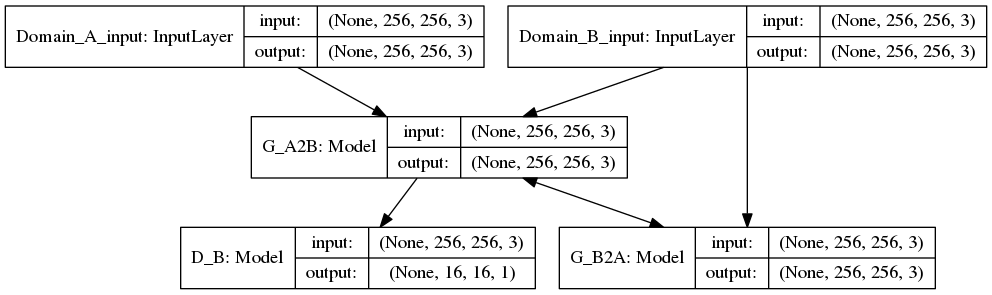

In [7]:
# CycleGAN model

def CycleGAN(D_B, G_A2B, G_B2A, input_shape=(256,256,3)):

  # inputs
  domain_A = Input(shape=input_shape, name='Domain_A_input')
  domain_B = Input(shape=input_shape, name='Domain_B_input')

  # model
  D_B.trainable = False # discriminator not trained while generator is trained
  G_A2B.trainable = True # only one generator trained at a time
  G_B2A.trainable = False # other generator used to compute loss

  # adversarial module:

  ## Generated Domain_B image from Domain_A and passed to Discriminator_B for 
  ## evaluation of adversarial loss and 
  ## forward loss computation
  generated_B = G_A2B(domain_A)
  dis_B_out = D_B(generated_B) # discriminator output - used for adversarial loss computation - ideal output: ones of patch dimension

  # Identity module: 
  ## given domainB input to A->B generator, output should be same as input
  ## used to retain color tint during style transfer
  identity_B = G_A2B(domain_B) # identity output - used to compute identity loss - ideal output: same as input

  # forward cyclic loop A-> B-> A : 
  ## the input to first generator and output of second generator should be same
  cycle_A = G_B2A(generated_B) # used to compute forward cycle loss - ideal output: same as input to other generator

  # backword cyclic loop B-> A -> B : the input and output should be same
  generated_A = G_B2A(domain_B) # same as forward cycle, in reverse
  cycle_B = G_A2B(generated_A) # used to compute reverse cycle loss

  # output
  model_outputs = [dis_B_out, identity_B, cycle_A, cycle_B]
  compile_losses = [lse, lse, cycle_loss, cycle_loss] #one to one mapping of output to loss function at that output
  compile_weights = [1.0, 5.0, 10.0, 10.0] # lambda=10.0 as mentioned in paper for cyclic loss

  GAN = Model(inputs=[domain_A, domain_B],outputs=model_outputs, name = 'CycleGAN')

  GAN.compile(optimizer=Adam(0.0002, 0.5, 0.999),loss=compile_losses,loss_weights=compile_weights)
  
  GAN.summary()
  return GAN

# https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/ - for graph visualization

D_A = discriminator(name='D_A')
D_B = discriminator(name='D_B')

G_A2B = generator(name='G_A2B')
G_B2A = generator(name='G_B2A')

GAN_A2B = CycleGAN(D_B, G_A2B, G_B2A) # half of cycle GAN A -> B transformation
GAN_B2A = CycleGAN(D_A, G_B2A, G_A2B) # half of cycle GAN B -> A transformation

# all variables declared globally
plot_model(GAN_A2B, to_file=base_path + '/CycleGAN_A2B.png', show_shapes=True, show_layer_names=True)
#plot_model(GAN_B2A, to_file=base_path + '/CycleGAN_B2A.png', show_shapes=True, show_layer_names=True)

### Tensorboard module

In [0]:
#Initializing tensorboard for GAN model 
tensorboard = TensorBoard(
log_dir = base_path + '/logs',
histogram_freq=0,
batch_size=1,
write_graph=True,
write_grads=True
)
tensorboard.set_model(GAN_A2B)

### Loading dataset

In [0]:
'''
# https://stackoverflow.com/questions/3451111/unzipping-files-in-python - unzipping file
import zipfile
with zipfile.ZipFile(base_path + '/horse2zebra.zip', 'r') as zip_ref:
    zip_ref.extractall(base_path)
'''

"\n# https://stackoverflow.com/questions/3451111/unzipping-files-in-python - unzipping file\nimport zipfile\nwith zipfile.ZipFile(base_path + '/horse2zebra.zip', 'r') as zip_ref:\n    zip_ref.extractall(base_path)\n"

In [9]:
# Reference for compressing dataset for quick loading - https://machinelearningmastery.com/cyclegan-tutorial-with-keras/ 
'''
# to load all images in a folder with specified target image size
def load_images(path, size=(256,256)):
	data_list = list()
	for filename in tqdm(listdir(path), desc = 'Loading' + path): #each file in the folder enumerated
		pixels = load_img(path + filename, target_size=size) #load and resize[for uniform input dimension to be used in the model] image to target size in PIL format
		pixels = img_to_array(pixels) #convert PIL format image to numpy array of 32-bit floating point values
		data_list.append(pixels) #store image vector in a list
	return asarray(data_list)   #return the image collection as a list

# dataset path
path = base_path + '/horse2zebra/' #primary folder
# load dataset A (horses)
domainA_train = load_images(path + 'trainA/') #trainA sub folder images loaded
print('Loaded domainA_train ', domainA_train.shape)
domainA_test = load_images(path + 'testA/') #testA sub folder images loaded
print('Loaded domainA_test ', domainA_test.shape)
#domainA = vstack((domainA_train, domainA_test)) #testA appended to trainA
#print('Loaded dataA: ', domainA.shape)
# load dataset B (zebras)
domainB_train = load_images(path + 'trainB/') #trainB sub folder images loaded
print('Loaded domainB_train: ', domainB_train.shape)
domainB_test = load_images(path + 'testB/') #testB sub folder images loaded
print('Loaded domainB_test: ', domainB_test.shape)
#domainB = vstack((domainB_train, domainB_test)) #testB images appended to trainB
#print('Loaded dataB: ', domainB.shape)

# https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez_compressed.html#numpy.savez_compressed
# compressing the dataset

# save as compressed numpy array
filename = base_path + '/horse2zebra_compressed.npz'
savez_compressed(filename, domainA_train, domainA_test, domainB_train, domainB_test)
print('Saved dataset: ', filename)
'''
# load the compressed dataset
# load the dataset
filename = base_path + '/horse2zebra_compressed.npz'
data = load(filename)
'''
# getting default column names of the .npz file
for k in data.files:
  print(k)
'''
domain_A_train, domain_A_test, domain_B_train, domain_B_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] 
# scale from [0,255] to [-1,1]
domain_A_train = (domain_A_train - 127.5) / 127.5
domain_A_test = (domain_A_test - 127.5) / 127.5
domain_B_train = (domain_B_train - 127.5) / 127.5
domain_B_test = (domain_B_test - 127.5) / 127.5
print('Loaded: ', domain_A_train.shape, domain_A_test.shape, domain_B_train.shape, domain_B_test.shape)

Loaded:  (1067, 256, 256, 3) (120, 256, 256, 3) (1334, 256, 256, 3) (140, 256, 256, 3)


In [0]:
'''
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(domain_A_train[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(domain_B_train[i].astype('uint8'))
pyplot.show()
'''

"\n# plot source images\nn_samples = 3\nfor i in range(n_samples):\n\tpyplot.subplot(2, n_samples, 1 + i)\n\tpyplot.axis('off')\n\tpyplot.imshow(domain_A_train[i].astype('uint8'))\n# plot target image\nfor i in range(n_samples):\n\tpyplot.subplot(2, n_samples, 1 + n_samples + i)\n\tpyplot.axis('off')\n\tpyplot.imshow(domain_B_train[i].astype('uint8'))\npyplot.show()\n"

### Initiating train phase

### Image Pool to train discriminator

In [0]:
# Usage of image pool reduces oscilation of the model - mentioned in paper
# Reused from official implementation - https://github.com/simontomaskarlsson/CycleGAN-Keras/blob/master/model.py
class ImagePool():
  def __init__(self, pool_size):
    self.pool_size = pool_size
    if self.pool_size > 0:
      self.num_imgs = 0
      self.images = []

  def query(self, images):
    if self.pool_size == 0:
      return images
    return_images = []
    for image in images:
      if len(image.shape) == 3:
          image = image[np.newaxis, :, :, :]

      if self.num_imgs < self.pool_size:  # fill up the image pool
        self.num_imgs = self.num_imgs + 1
        if len(self.images) == 0:
            self.images = image
        else:
            self.images = np.vstack((self.images, image))

        if len(return_images) == 0:
            return_images = image
        else:
            return_images = np.vstack((return_images, image))

      else:  # 50% chance that we replace an old synthetic image
        p = random.uniform(0, 1)
        if p > 0.5:
          random_id = random.randint(0, self.pool_size - 1)
          tmp = self.images[random_id, :, :, :]
          tmp = tmp[np.newaxis, :, :, :]
          self.images[random_id, :, :, :] = image[0, :, :, :]
          if len(return_images) == 0:
            return_images = tmp
          else:
            return_images = np.vstack((return_images, tmp))
        else:
          if len(return_images) == 0:
            return_images = image
          else:
            return_images = np.vstack((return_images, image))

    return return_images

### Defining train phase

In [0]:
# training phase
def train(epochs=20, batch_size=1, start_epoch=0, identity=False): # identity loss incorporated in GAN model. So, ignored in train phase 
  label_shape = (batch_size,) + D_A.output_shape[1:] # (1,16,16,1) = discriminator output shape = patch_shape
  ones = np.ones(shape=label_shape) # real image discriminator target tensor
  zeros = np.zeros(shape=label_shape) # generated image discriminator target tensor

  if(identity):
    # for identity loss computation
    G_A2B.compile(optimizer=Adam(2e-4, 0.5, 0.999), loss='MAE')
    G_B2A.compile(optimizer=Adam(2e-4, 0.5, 0.999), loss='MAE')

  # initializing iimage pools for both domains
  generated_pool_A = ImagePool(50)
  generated_pool_B = ImagePool(50)

  for epoch in range(start_epoch, start_epoch + epochs):
    start = time.time() # to check time taken per epoch
    train_A = domain_A_train
    train_B = domain_B_train

    # randomize the train datasets for each epoch
    train_A_index = np.random.randint(len(train_A), size=len(train_A)) # randomized index values of size number of images in domain A to ensure randomness on each epoch
    train_B_index = np.random.randint(len(train_B), size=len(train_B))
    iterations = max(len(train_A), len(train_B)) # to ensure all images are used for training in each epoch
    modulus_A = len(train_A) # to cycle back images when all are used up in a domain
    modulus_B = len(train_B)

    for i in range(iterations): 
      # sampling technique
      sample_A = train_A[train_A_index[i%modulus_A]] # picked image from domain A for this iteration
      sample_B = train_B[train_B_index[i%modulus_B]] # picked image from domain_B for this iteration

      # https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae - for reshaping the image to 4D
      sample_A = sample_A[np.newaxis, :]
      sample_B = sample_B[np.newaxis, :]

      # print(sample_A.shape)

      # newly generated images
      generated_images_B = G_A2B.predict(sample_A)
      generated_images_A = G_B2A.predict(sample_B)

      # images used from ImagePool for current iteration
      generated_images_A = generated_pool_A.query(generated_images_A)
      generated_images_B = generated_pool_B.query(generated_images_B)
      '''
      pyplot.axis('off')
      pyplot.imshow(generated_images_B[0].astype('uint8'))   
      pyplot.show() 
      '''
      # Discriminator training module
      DA_loss_real = D_A.train_on_batch(x=sample_A, y=ones) # (1,16,16,1) # target is all ones for real images
      DA_loss_fake = D_A.train_on_batch(x=generated_images_A, y=zeros) # (1,16,16,1) # target is all zeros for fake images
      DB_loss_real = D_B.train_on_batch(x=sample_B, y=ones) # (1,16,16,1) # target is all ones for real images
      DB_loss_fake = D_B.train_on_batch(x=generated_images_B, y=zeros) # (1,16,16,1) # target is all zeros for fake images

      DA_loss = DA_loss_real + DA_loss_fake # overall discriminator loss is sum of real and fake loss
      DB_loss = DB_loss_real + DB_loss_fake

      # Generator training module
      target_data_A2B = [ones, sample_B, sample_A, sample_B]  # Comparing output with corresponding expected outputs in A2B transformation (mentioned in detail in GAN definition module)
      target_data_B2A = [ones, sample_A, sample_B, sample_A]  # Comparing output with corresponding targets in B2A transformation

      GAN_loss_A2B = GAN_A2B.train_on_batch(x=[sample_A, sample_B], y=target_data_A2B) # returns cycle_loss1, cycle_loss1, identity_loss and adversarial loss for generator
      GAN_loss_B2A = GAN_B2A.train_on_batch(x=[sample_B, sample_A], y=target_data_B2A) 

      # final losses computed and recorded in log
      g_loss_A2B = GAN_loss_A2B[0]
      g_loss_B2A = GAN_loss_B2A[0]
      identity_loss_B = GAN_loss_A2B[1] # identity loss based on A2B generator
      identity_loss_A = GAN_loss_B2A[1] # identity loss based on B2A generator
      cycle_loss_A = GAN_loss_A2B[2] + GAN_loss_B2A[3] # total A -> B -> A cycle loss from both generators
      cycle_loss_B = GAN_loss_A2B[3] + GAN_loss_B2A[2] # total B -> A -> B cycle loss from both generators

      # Identity loss computation
      if identity and i!=0 and (i % 100 == 0 or i==iterations-1): # computed once every 100 iterations
        # https://github.com/eriklindernoren/PyTorch-GAN/issues/59 - identity loss reason for why this combination of input and output
        G_A2B_identity_loss = G_A2B.train_on_batch(x=sample_B, y=sample_B) # comparing generated image to the source type same image. It is expected to return same image as input in ideal case
        G_B2A_identity_loss = G_B2A.train_on_batch(x=sample_A, y=sample_A)
        print('iter_{iter}>>> G_A2B_identity_loss: {a:.3f} \t G_B2A_identity_loss: {b:.3f}'.format(iter=i, a=G_A2B_identity_loss, b=G_B2A_identity_loss))

      # code liveliness check and epoch iteration count update
      if i%100 == 0:
        print(i)

      # tensorboard loging module
      if i== iterations-1: # record data for tensorboard at end of epoch
        # store scalars in tensorboard logs
      	tensorboard.on_epoch_end(epoch, 
                                {"Epoch:":epoch , 
                                 "D_A_loss": DA_loss , 
                                 "D_B_loss": DB_loss, 
                                 "G_A2B_loss": g_loss_A2B, 
                                 "G_B2A_loss": g_loss_B2A,
                                 "identity_loss_A": identity_loss_A,
                                 "identity_loss_B": identity_loss_B,
                                 "cycle_loss_A": cycle_loss_A,
                                 "cycle_loss_B": cycle_loss_B
                                 })

    # model save module
    if epoch!=0 and (epoch%20 == 0 or epoch == start_epoch + epochs-1): # save model parameters once every 20 epochs and last epoch of current run
      D_A.save_weights(base_path + '/D_A_epoch_' + str(epoch) + '.hdf5') 
      D_B.save_weights(base_path + '/D_B_epoch_' + str(epoch) + '.hdf5') 
      G_A2B.save_weights(base_path + '/G_A2B_epoch_' + str(epoch) + '.hdf5') 
      G_B2A.save_weights(base_path + '/G_B2A_epoch_' + str(epoch) + '.hdf5')
      print('Saved model weights')
      
    # print A->B->A transformation on a random image of horse  
    sample_A = train_A[np.random.randint(len(train_A))]
    sample_A = sample_A[np.newaxis, :]
    generated_img = G_A2B.predict(sample_A)
    '''
    # scale all pixels from [-1,1] to [0,1]
    generated_img[0] = (generated_img[0] + 1) / 2.0
    generated_img[0] = generated_img[0]*255
    '''
    reconstructed_img = G_B2A.predict(generated_img)
    '''
    pyplot.axis('off')
    pyplot.imshow(generated_img[0].astype('uint8'));    
    pyplot.show()
    '''
    # scale all pixels from [-1,1] to [0,1]
    sample_A[0] = (sample_A[0] + 1) / 2.0
    #sample_A[0] = sample_A[0]*255

    generated_img[0] = (generated_img[0] + 1) / 2.0
    #generated_img[0] = generated_img[0]*255

    reconstructed_img[0] = (reconstructed_img[0] + 1) / 2.0
    #reconstructed_img[0] = reconstructed_img[0]*255
    '''
    print(sample_A[0].shape)
    print(generated_img[0].shape)
    print(reconstructed_img[0].shape)
    '''
    images = (sample_A[0], generated_img[0], reconstructed_img[0])
    titles = ['Real', 'Generated', 'Reconstructed']

    # print(len(images))    

    # ploting original, generated and reconstructed image in order in a row
    for img in range(len(images)):
      print(img)
      # define subplot
      pyplot.subplot(1, len(images), 1 + img)
      # turn off axis
      pyplot.axis('off')
      # plot raw pixel data
      pyplot.imshow(images[img])
      # title
      pyplot.title(titles[img])
    pyplot.show()
  
    # save plot to file
    image_path = base_path + '/generated_images/generated_image_'+ str(epoch) + '.png'
    pyplot.savefig(image_path)
    print('Saved' + image_path)
    pyplot.close()

    end = time.time() - start
    print('Epoch_{ep}>>> time_per_epoch: {a:.3f} sec => ~{b:3d} min'.format(ep=epoch, a=end, b=round(end/60)))

Loaded model weights from epoch 20


/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


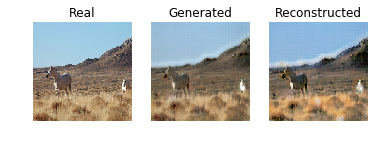

Saved./generated_images/generated_image_21.png
Epoch_21>>> time_per_epoch: 993.682 sec => ~ 17 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


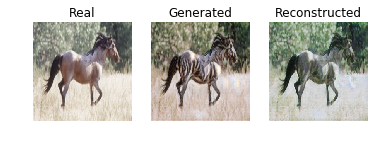

Saved./generated_images/generated_image_22.png
Epoch_22>>> time_per_epoch: 993.366 sec => ~ 17 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


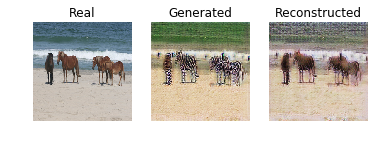

Saved./generated_images/generated_image_23.png
Epoch_23>>> time_per_epoch: 990.678 sec => ~ 17 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


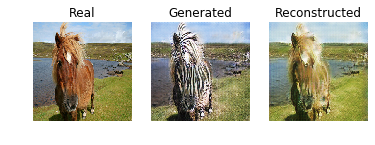

Saved./generated_images/generated_image_24.png
Epoch_24>>> time_per_epoch: 988.932 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


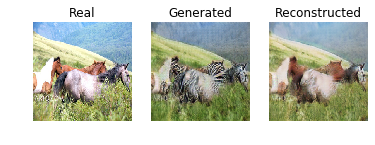

Saved./generated_images/generated_image_25.png
Epoch_25>>> time_per_epoch: 994.181 sec => ~ 17 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


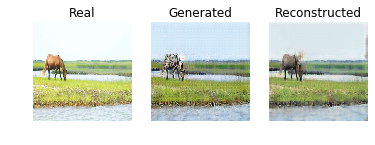

Saved./generated_images/generated_image_26.png
Epoch_26>>> time_per_epoch: 988.942 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


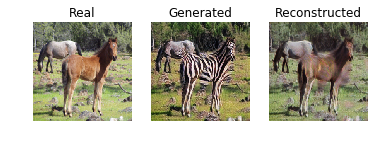

Saved./generated_images/generated_image_27.png
Epoch_27>>> time_per_epoch: 987.466 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


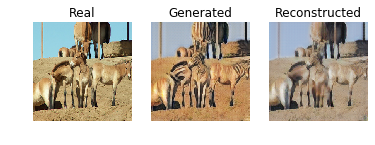

Saved./generated_images/generated_image_28.png
Epoch_28>>> time_per_epoch: 987.675 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


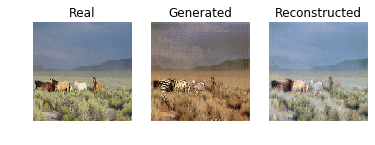

Saved./generated_images/generated_image_29.png
Epoch_29>>> time_per_epoch: 986.678 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


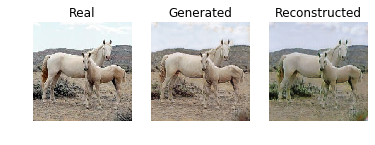

Saved./generated_images/generated_image_30.png
Epoch_30>>> time_per_epoch: 987.127 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


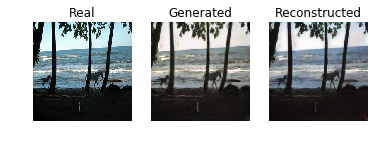

Saved./generated_images/generated_image_31.png
Epoch_31>>> time_per_epoch: 988.304 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


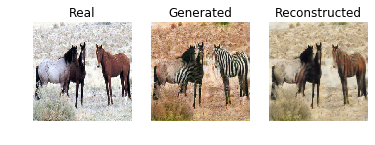

Saved./generated_images/generated_image_32.png
Epoch_32>>> time_per_epoch: 988.410 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


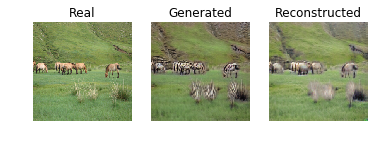

Saved./generated_images/generated_image_33.png
Epoch_33>>> time_per_epoch: 989.621 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


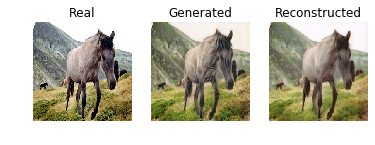

Saved./generated_images/generated_image_34.png
Epoch_34>>> time_per_epoch: 989.648 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


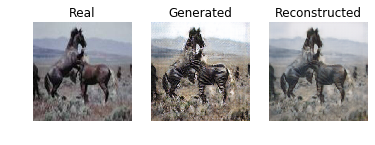

Saved./generated_images/generated_image_35.png
Epoch_35>>> time_per_epoch: 988.074 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


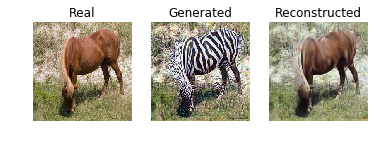

Saved./generated_images/generated_image_36.png
Epoch_36>>> time_per_epoch: 987.476 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


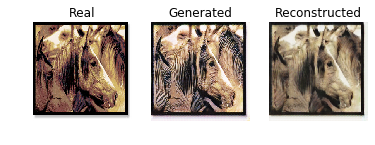

Saved./generated_images/generated_image_37.png
Epoch_37>>> time_per_epoch: 988.107 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


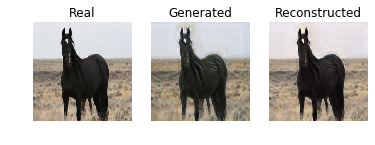

Saved./generated_images/generated_image_38.png
Epoch_38>>> time_per_epoch: 987.336 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


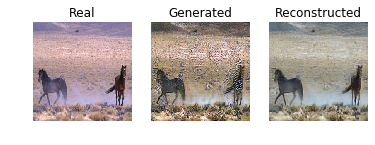

Saved./generated_images/generated_image_39.png
Epoch_39>>> time_per_epoch: 986.783 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Saved model weights
0
1
2


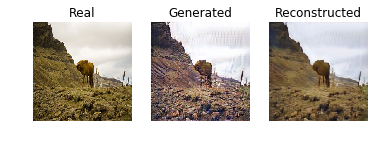

Saved./generated_images/generated_image_40.png
Epoch_40>>> time_per_epoch: 988.207 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


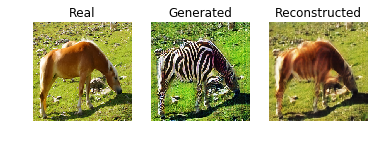

Saved./generated_images/generated_image_41.png
Epoch_41>>> time_per_epoch: 987.596 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


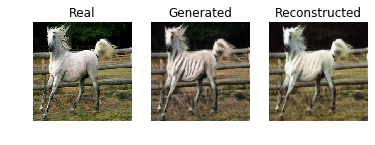

Saved./generated_images/generated_image_42.png
Epoch_42>>> time_per_epoch: 987.139 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


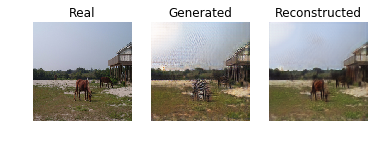

Saved./generated_images/generated_image_43.png
Epoch_43>>> time_per_epoch: 987.053 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


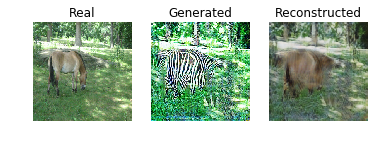

Saved./generated_images/generated_image_44.png
Epoch_44>>> time_per_epoch: 987.214 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


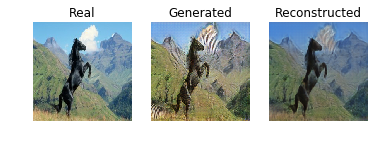

Saved./generated_images/generated_image_45.png
Epoch_45>>> time_per_epoch: 987.474 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


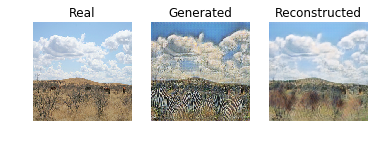

Saved./generated_images/generated_image_46.png
Epoch_46>>> time_per_epoch: 988.704 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


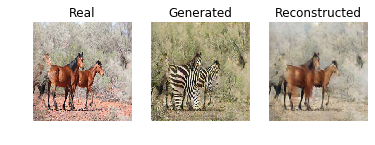

Saved./generated_images/generated_image_47.png
Epoch_47>>> time_per_epoch: 988.397 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


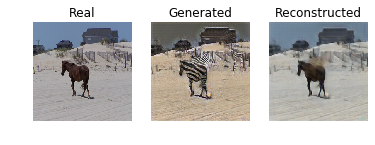

Saved./generated_images/generated_image_48.png
Epoch_48>>> time_per_epoch: 988.852 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
0
1
2


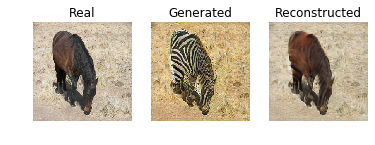

Saved./generated_images/generated_image_49.png
Epoch_49>>> time_per_epoch: 988.070 sec => ~ 16 min
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Saved model weights
0
1
2


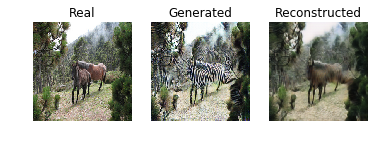

Saved./generated_images/generated_image_50.png
Epoch_50>>> time_per_epoch: 987.276 sec => ~ 16 min


In [16]:
%matplotlib inline #matplotlib magic to display matplotlib plotted images
import sys
from numpy import vstack

last_epoch = 20 # default zero if starting from the beginning. Else epoch number of last saved epoch model

if(last_epoch!=0): # if first run, won't have any saved models. So, don't load
  D_A.load_weights(base_path + '/D_A_epoch_' + str(last_epoch) + '.hdf5') 
  D_B.load_weights(base_path + '/D_B_epoch_' + str(last_epoch) + '.hdf5') 
  G_A2B.load_weights(base_path + '/G_A2B_epoch_' + str(last_epoch) + '.hdf5') 
  G_B2A.load_weights(base_path + '/G_B2A_epoch_' + str(last_epoch) + '.hdf5')
  print('Loaded model weights from epoch ' + str(last_epoch))

sys.stdout.flush() #clearing output buffer
train(epochs=30, batch_size=1, start_epoch=last_epoch+1) # to run epochs #of_epochs from the previous save point

In [0]:
%load_ext tensorboard
%tensorboard --logdir ./logs/

In [18]:
# Linking with GCP - https://medium.com/@senthilnathangauthamA/colab-gcp-compute-how-to-link-them-together-98747e8d940e
# https://cloud.google.com/sdk/docs/quickstart-debian-ubuntu
# https://forum.clouderizer.com/t/error-on-starting-gcp/217/5
# https://stackoverflow.com/questions/45155619/gcloud-compute-ssh-refuses-connection-return-code-255/45384397

# password during ssh means SSHKey passphrase
# no adblocker to connect to localhost

'''
# https://forums.fast.ai/t/tip-clear-tensorflow-gpu-memory/1979/4
from keras import backend as K
K.get_session().close()
cfg = tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(tf.Session(config=cfg))
'''

!nvidia-smi


Fri Nov 29 17:02:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    39W / 300W |  15671MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

0
1


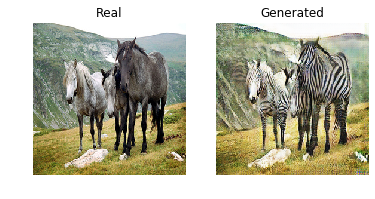

In [30]:
# testing module
load_epoch = 50
G_A2B.load_weights(base_path + '/G_A2B_epoch_' + str(load_epoch) + '.hdf5') 

random_ind = np.random.randint(len(domain_A_test),size=1)
sample = domain_A_test[random_ind]
generated_img = G_A2B.predict(sample)

sample = (sample + 1) / 2.0
generated_img = (generated_img + 1) / 2.0

images = (sample[0], generated_img[0])
titles = ['Real', 'Generated']

# print(len(images))    

# ploting original, generated and reconstructed image in order in a row
for img in range(len(images)):
  print(img)
  # define subplot
  pyplot.subplot(1, len(images), 1 + img)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(images[img])
  # title
  pyplot.title(titles[img])
pyplot.show()
